# Imports

In [1]:
import os
import os.path
import glob
import pandas as pd
import geopandas as gpd
import json
import time

from tqdm.notebook import tqdm
tqdm.pandas()
import contextily as ctx

from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

import overpy
overpass = overpy.Overpass()

%matplotlib inline

droot = './draft-data/'

/Users/ivo/opt/anaconda3/envs/thesis-env/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Get weighted centroid of a dataframe
def get_weighted_centroid(gdf, column, return_gdf=False):
    """Calculates statistical mean center based on a weighing value."""
    
    assert isinstance(gdf, gpd.GeoDataFrame)
    assert isinstance(column, str)
    assert column in gdf.columns
    
    # Mean center according to this http://resources.esri.com/help/9.3/arcgisengine/java/gp_toolref/spatial_statistics_tools/how_mean_center_spatial_statistics_works.htm
    weighted_x = (gdf.centroid.x * gdf[column]).sum() / gdf[column].sum()
    weighted_y = (gdf.centroid.y * gdf[column]).sum() / gdf[column].sum()
    weighted_centroid = Point(weighted_x, weighted_y)
    
    if return_gdf: 
        return gpd.GeoDataFrame({'geometry': [weighted_centroid]}, crs=gdf.crs)
    else:
        return weighted_centroid
    

In [3]:
def create_linestring_routes(gdf, n_routes, randomseed):
    src = gdf.sample(n=n_routes, weights='cell_pop', random_state=randomseed)
    dst = gdf.sample(n=n_routes, weights='cell_pop', random_state=randomseed+1)
    
    return gpd.GeoDataFrame(
        [{
            'src_cell_id': src.iloc[i].id,
            'src_cell_pop': src.iloc[i].cell_pop,
            'dst_cell_id': dst.iloc[i].id,
            'dst_cell_pop': dst.iloc[i].cell_pop,
            'geometry': LineString([src.centroid.iloc[i], dst.centroid.iloc[i]])
        } for i in range(len(src)) ],
        crs=gdf.crs,
    )

# Procedures

## Town Halls

In [4]:
def get_centroid_townhall(row):
    
    cityname = row.name
    gdf_pop = pd.read_pickle(os.path.join(droot, 'populationmasks', cityname + '.pcl'))
    
    # Request Townhouse Information
    bounds = gdf_pop.total_bounds
    bbox = (bounds[1], bounds[0], bounds[3], bounds[2])
    
    # Sometimes overpass overloads, then we wait for 5 seconds and try again.
    for retries in range(10):
        # print(cityname, ": attempt ", retries)
        try:
            query = """
                (
                  node[amenity=townhall]{bbox};
                  relation[amenity=townhall]{bbox};
                  way[amenity=townhall]{bbox};
                );
                out body;
                >;
                out skel qt;
            """.format(bbox=bbox)
            result = overpass.query(query)
        except: #OverpassTooManyRequests:
            time.sleep(5)
            continue
        else:
            break
    
    if len(result.nodes) == 0:
        print(cityname, ': no results using query')
        print(query)
        return row
    
    # Create townhouse DataFrame with two distances
    nodes_gdf = gpd.GeoDataFrame([{
        'osm_id': node.id, 
        'townhall_name': node.tags.get('name', 'None'), 
        'geometry': Point(node.lon, node.lat)} for node in result.nodes],
    ).set_index('osm_id')
    
    # Get the fourth quartile of highest populations per cell (bins[3])
    series, bins = pd.qcut(gdf_pop.cell_pop, 4, retbins=True)
    binned = gdf_pop[gdf_pop.cell_pop > bins[3]]
    nodes_gdf['distance_centroid'] = nodes_gdf.distance(get_weighted_centroid(binned, 'cell_pop'))
    closest = nodes_gdf.loc[nodes_gdf.distance_centroid == nodes_gdf.distance_centroid.min()].iloc[0]
    
    row.update(closest)
    
    return row
    

In [8]:
city_list_df = pd.read_csv(os.path.join(droot, 'citylist.csv'))
city_list_df = city_list_df[city_list_df.Order == 1]

# Set up default DataFrame with all cities as index.
townhalls_gdf = gpd.GeoDataFrame(columns=['city', 'osm_id', 'townhall_name', 'geometry'])
townhalls_gdf.city = city_list_df.City
townhalls_gdf = townhalls_gdf.set_index('city')

# Fetch the previous DataFrame and get existing townhalls
townhalls_path = os.path.join(droot, 'townhalls.pcl')
if os.path.exists(townhalls_path):
    townhalls_gdf.update(pd.read_pickle(townhalls_path))

# Update all non-cached records from OverPass OSM.
empty = townhalls_gdf.geometry.isna()
townhalls_gdf.loc[empty] = townhalls_gdf[empty].progress_apply(get_centroid_townhall, axis=1)

# Set CRS and write out to disk.
townhalls_gdf.crs = 'epsg:4326'
townhalls_gdf.to_pickle(townhalls_path)
townhalls_gdf.head(40)

,osm_id,townhall_name,geometry
city,,,
Vienna,NaN,None,POINT (16.38821 48.20136)
Brussels,NaN,None,POINT (4.35232 50.84642)
Berlin,NaN,Senatsverwaltung für Inneres und Sport,POINT (13.41160 52.51687)
Copenhagen,NaN,None,POINT (12.53228 55.67843)
Madrid,NaN,None,POINT (-3.69260 40.41831)
Paris,NaN,None,POINT (2.35167 48.85595)
London,NaN,None,POINT (-0.12477 51.52910)
Luxembourg,NaN,None,POINT (6.13024 49.61031)
Amsterdam,NaN,Stadsloket Centrum,POINT (4.90000 52.36822)


In [ ]:
# Older visualisation technique.
# Shows all townhouses in the bbox and visualises closest one.
fig, axs = plt.subplots(ncols=2, nrows=len(city_list) // 2 + 1, figsize=(15, len(city_list)*5))
axs = axs.flatten()
fig.patch.set_facecolor('white')
fig.suptitle('Town halls in region & closest to weighted centroid.')
i=0
townhalls = pd.read_pickle(townhalls_path)

for city in city_list:
    
    gdf_pop = pd.read_pickle(os.path.join(droot, 'populationmasks', city + '.shp')
    
    # Plot binned 4th quartile.
    series, bins = pd.qcut(gdf_pop.cell_pop, 6, retbins=True)
    binned = gdf_pop[gdf_pop.cell_pop > bins[5]]
    
    gdf_pop.plot(ax=axs[i], column='cell_pop', scheme='quantiles', cmap='plasma', alpha=0.5)
    
    townhalls[townhalls.city == city.City].plot(ax=axs[i], column='d_binned_centroid', color='black', k=15)
    
    get_weighted_centroid(binned, column='cell_pop', return_gdf=True).plot(ax=axs[i], color='red')
    
    ctx.add_basemap(axs[i], source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_pop.crs)
    axs[i].set_title(cityname)
    
    i+=1

## Random Routes

In [32]:
city_list_df = pd.read_csv(os.path.join(droot, 'citylist.csv'))
city_list_df = city_list_df[city_list_df.Order == 1]

# Read file
for city in tqdm(city_list):
    
    city_gpd = pd.read_pickle(city)
    cityname = city[29:-4]

    # Get the fourth quartile of highest populations per cell (bins[3])
    series, bins = pd.qcut(gdf_pop.cell_pop, 4, retbins=True)
    binned = gdf_pop[gdf_pop.cell_pop > bins[3]]

    # Get the higher routes
    high_routes = create_linestring_routes(binned, n_routes=1000, randomseed=4)

    randomroutes_path = os.path.join(droot, 'randomroutes', city.City + '.pcl')
    high_routes.to_pickle(randomroutes_path)

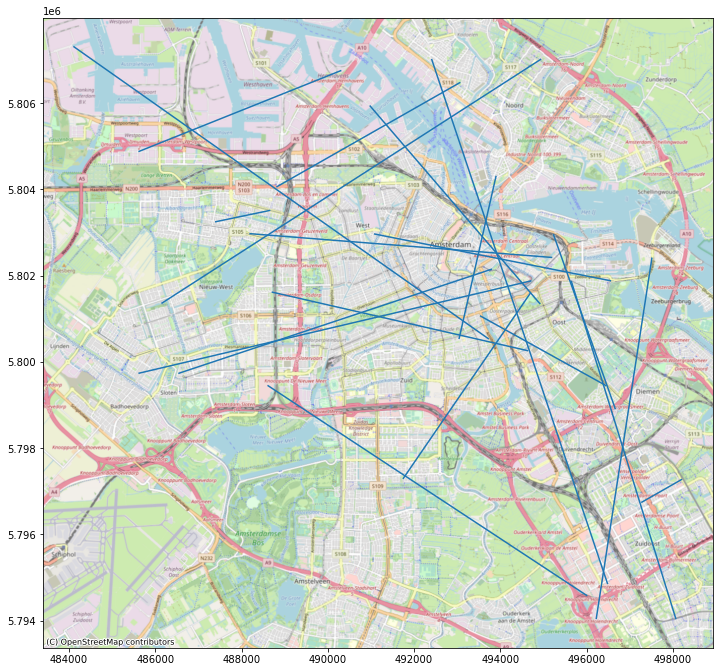

In [41]:
ax = routes.sample(20).plot(figsize=(12,12))
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_pop.crs)